# Lesson 6. Advanced Parameter Estimation

In this Jupyter Notebook more advanced techniques for performing parameter estimation is presented. The following points will be taught in this lesson:
* Selection of least square algorithm
* Adding lower- and upper bounds to parameters in parameter estimation
* Applying multiple random start, to help find the global minimum of the objective function
* Enabling and applying multithreading

The following code block must be run to perform any calculations in this document:

In [1]:
from pythermo import pythermo as pt #Required

import numpy as np #Recommended
from matplotlib import pyplot as plt #Recommended - used for plotting

### Experimental Data Loading
In this project we will once again show examples using the molecule triethylen-glycol (TEG). Pure component data for this molecule is loaded in the following code block.

In [2]:
#Here we initialize the class
exp_data = pt.Experimental_Data()

#By using the "Add" class function, we may add experimental data to the class. First we add vapor pressure data
filename_psat = 'experimental_data/TEG_vapor_pressure.csv'
datatype_psat = 'PSat'
identifier_psat = 'teg_psat'
exp_data.Add(filename_psat, datatype_psat, identifier_psat)

#Similarly, we add liquid density data.
filename_rho = 'experimental_data/TEG_liq_density.csv'
datatype_rho = 'rho'
identifier_rho = 'teg_rho'
exp_data.Add(filename_rho, datatype_rho, identifier_rho)



Furthermore, we would like to impose a temperature interval on the data in the range of 0.4-0.9 Tr.

In [3]:
#It is common to limit the pure component data to a specific temperature range, typically expressed as an
#an interval of reduced temperatures. If we seek to remove data outside these region, we impose the interval by 
#using the ReducedTemperature function

Tr_min = 0.4 #Reduced temperature min
Tr_max = 0.9 #Reduced temperature max
Tc = 769.5 #Critical temprature [K]
exp_data.ReducedTemperature(Tr_min, Tr_max, Tc)

print("After adjusting for reduced temperature")
exp_data.Show_list()

After adjusting for reduced temperature
Data Type        Dim (r x c)     Name           
-------------------------------------------------------------
PSat             38x2            teg_psat       
rho              50x2            teg_rho        




### Loading TEG properties
Critical properties and model parameters for TEG are defined below, they are the same as previous lessons.

In [4]:
crit_props = {
    "Tc" : 769.5,
    "Pc" : 33.2,
    "Om" : 0.05 
}

original_params = {
    "b0" : 128.93,
    "Gamma" : 3622.5,
    "c1" : 0.9100,
    "AssocEng" :  1420.0,
    "AssocVol" : 20.0
}

AssocSch = 24 #Corresponds to 6D associaton scheme

In [5]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

### Selecting an optimization algorithm
In this section we will learn how to select an optimization algorithm. The PyTherm package supports three optimization algorithms for least square problems:
* Trust Region Reflective
* Dogleg with Rectangular Trust Regions
* Levenberg-Marquardt

In [6]:
#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

#Now we set the optimization algorithm
algorithm = "trf" # lm - levenberg marquardt, trf - trust region reflective, dogbox - dogleg algorithm
optimizer.Set_Optimization_Algorithm(algorithm)

#Now the optimizer have enough information to perform parameterization. Keep in mind that Optimizer is solely for
#CPA model, a
opti_params = optimizer.Calculation()

In [7]:
print(opti_params)

{'b0': 128.98011009517683, 'Gamma': 3619.2078581514215, 'c1': 1.1761777883654498, 'AssocVol': 16.556632364794833, 'AssocEng': 1342.3205407795367}


### Setting upper and lower bounds for decision variables

In [8]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

In [9]:
#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

#Now we set the optimization algorithm (remember, levenberg-marquardt does NOT work with bounds)
algorithm = "trf" # lm - levenberg marquardt, trf - trust region reflective, dogbox - dogleg algorithm
optimizer.Set_Optimization_Algorithm(algorithm)

bounds = {
    "b0" : [125,135],
    "Gamma" : [3000,4000],
    "c1" : [0.5,1.0],
    "AssocVol" : [10,30],
    "AssocEng" : [1000, 2000]
}

optimizer.Add_Bounds(bounds)



#Now the optimizer have enough information to perform parameterization. Keep in mind that Optimizer is solely for
#CPA model, a
opti_params = optimizer.Calculation()

In [10]:
print(opti_params)

{'b0': 127.6928086948071, 'Gamma': 3251.069767412638, 'c1': 0.9999672325143967, 'AssocVol': 15.807067813767151, 'AssocEng': 1793.906834027094}


### Fixing decision variables

In [11]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

In [12]:
#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

#Now we set the optimization algorithm (remember, levenberg-marquardt does NOT work with bounds)
algorithm = "trf" # lm - levenberg marquardt, trf - trust region reflective, dogbox - dogleg algorithm
optimizer.Set_Optimization_Algorithm(algorithm)

fixed = {
    "b0" : True,
    "Gamma" : False,
    "c1" : False,
    "AssocVol" : False,
    "AssocEng" : False
}
optimizer.Fix_Variables(fixed)



#Now the optimizer have enough information to perform parameterization. Keep in mind that Optimizer is solely for
#CPA model, a
opti_params = optimizer.Calculation()

In [13]:
print(opti_params)

{'b0': 128.93, 'Gamma': 3634.5785403211958, 'c1': 1.2160450513788166, 'AssocVol': 16.683441918842224, 'AssocEng': 1279.9272478645348}


### How to use multiple initial conditions for finding global minimum

In [14]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

In [15]:
#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

#Now we set the optimization algorithm
algorithm = "trf" # lm - levenberg marquardt, trf - trust region reflective, dogbox - dogleg algorithm
optimizer.Set_Optimization_Algorithm(algorithm)

bounds = {
    "b0" : [125,135],
    "Gamma" : [3000,4000],
    "c1" : [0.5,1.5],
    "AssocVol" : [10,30],
    "AssocEng" : [1000, 2000]
}
iterations = 3
optimizer.Setup_Multistart(bounds, iterations)

opti_params_multistart = optimizer.Calculation(MultiStart = True) 

Iteration 1
Iteration 2
Iteration 3


In [16]:
print(opti_params_multistart)

{'b0': 128.71647234573916, 'Gamma': 3762.644070405989, 'c1': 1.2778718799152509, 'AssocVol': 16.712552544370098, 'AssocEng': 1072.25404032103}


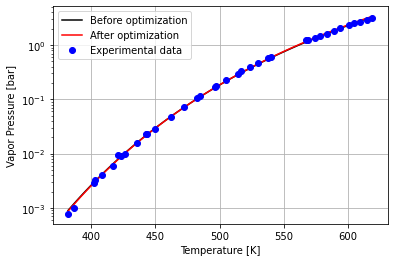

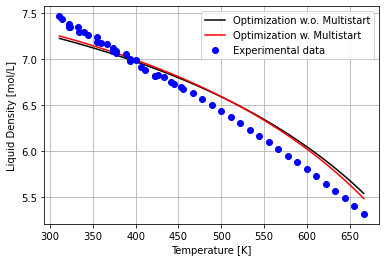

In [17]:
n = 100


exp_psat = exp_data.Retrieve_data('teg_psat')
exp_rho = exp_data.Retrieve_data('teg_rho')

expT_psat = exp_psat[:,0]
expP = exp_psat[:,1]

expT_rho = exp_rho[:,0]
expRho = exp_rho[:,1]

T_model_psat = np.linspace(min(expT_psat),max(expT_psat),n)
T_model_rho = np.linspace(min(expT_rho),max(expT_rho),n)

P_model = np.zeros(n) #Memory allocation - Good practice, more efficient
rho_model = np.zeros(n) #Memory allocation - Good practice, more efficient
P_model_multi = np.zeros(n) #Memory allocation - Good practice, more efficient
rho_model_multi = np.zeros(n) #Memory allocation - Good practice, more efficient


Thermo_improved = pt.Model()
Thermo_improved.NoPureComp(1)
Thermo_improved.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo_improved.CPAParams(1,opti_params["b0"],opti_params["Gamma"],opti_params["c1"])
Thermo_improved.AssocParams(1,AssocSch,opti_params["AssocVol"],opti_params["AssocEng"])

Thermo_improved.Setup_Thermo()

for i in range(0,n):
    P_model[i], b, c = Thermo_improved.PBubble(T_model_psat[i],[1.0])
    rho_model[i] = Thermo.LiqRho(T_model_rho[i],[1.0])


Thermo_improved = pt.Model()
Thermo_improved.NoPureComp(1)
Thermo_improved.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo_improved.CPAParams(1,opti_params_multistart["b0"],opti_params_multistart["Gamma"],opti_params_multistart["c1"])
Thermo_improved.AssocParams(1,AssocSch,opti_params_multistart["AssocVol"],opti_params_multistart["AssocEng"])

Thermo_improved.Setup_Thermo()

for i in range(0,n):
    P_model_multi[i], b, c = Thermo_improved.PBubble(T_model_psat[i],[1.0])
    rho_model_multi[i] = Thermo.LiqRho(T_model_rho[i],[1.0])

Thermo_improved.Finishup_Thermo()
#-----------------------------------------------------------------------------------

plt.plot(T_model_psat,P_model,color="black")
plt.plot(T_model_psat,P_model_multi,color="red")
plt.plot(expT_psat,expP,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Vapor Pressure [bar]")
plt.yscale('log')

plt.legend(["Before optimization","After optimization","Experimental data"])
plt.grid()
plt.show()

plt.plot(T_model_rho,rho_model,color="black")
plt.plot(T_model_rho,rho_model_multi,color="red")
plt.plot(expT_rho,expRho,'o',color="blue",markersize=  6)
plt.xlabel("Temperature [K]")
plt.ylabel("Liquid Density [mol/L]")
plt.legend(["Optimization w.o. Multistart","Optimization w. Multistart","Experimental data"])
plt.grid()
plt.show()

Implement

- Particle Swarm
- Difference evolution (or differential)

In [18]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = pt.Model()

Thermo.NoPureComp(1)
Thermo.CritProps(1,crit_props["Tc"], crit_props["Pc"], crit_props["Om"])
Thermo.CPAParams(1,original_params["b0"],original_params["Gamma"],original_params["c1"])
Thermo.AssocParams(1,AssocSch,original_params["AssocVol"],original_params["AssocEng"])

In [19]:
#From here we create a Optimizer object
optimizer = pt.Optimizer()

#The optimizer is now given a model to use, the Model object
optimizer.Add_Model(Thermo)

#Now we add the experimental data object to the Optimizer object
optimizer.Add_Experimental_Data(exp_data)

bounds = {
    "b0" : [125,135],
    "Gamma" : [3000,4000],
    "c1" : [0.5,1.0],
    "AssocVol" : [10,30],
    "AssocEng" : [1000, 2000]
}
optimizer.Add_Bounds(bounds)


opti_params = optimizer.PSO(500, {'stable_iter' : 50})

NameError: name 'PSO_minimize' is not defined

In [ ]:
print(opti_params)